In [1]:
import pandas as pd
from matplotlib.patches import Patch
from pandas import DataFrame, Series
import PyPDF2
from PyPDF2 import PdfFileReader
import math
import requests
import regex as re
import datetime
import matplotlib 
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import numpy as np
from datetime import datetime

In [2]:
plt.rcParams['font.size']=13

In [3]:
meeting = DataFrame(pd.read_csv("Board Committee Commission Meeting Data.csv"))
agendas = meeting['Agenda_Link']
notes = meeting['Minutes_Link']

In [4]:
for i in range(len(meeting)):
    new = re.sub(r"\s", "", meeting['Meeting_ID'][i])
    meeting['Meeting_ID'][i] = new

<ipython-input-4-77a6d85d7f34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meeting['Meeting_ID'][i] = new


In [5]:
meeting['Duration_minutes'] = meeting['Duration'] #copy a column so that I have one to replace with the cell below

In [6]:
for i in range(len(meeting['Duration'])):
    time = re.split(':',meeting['Duration'][i])
    time = [int(x) for x in time]
    seconds = time[0]*60 + time[1] + time[2]/60
    meeting.iloc[i,10] = seconds

In [7]:
dates = []
starting = []
for i in meeting['Zoom_Meeting_Start_Time']:
    unformatted = i.split()[0]
    time = i.split()[1]
    datetime = datetime.strptime(unformatted , '%m/%d/%Y')
    time_start = datetime.strptime(time , '%H:%M')
    dates.append(datetime)
    starting.append(time_start)


In [8]:
day_of_week = [x.strftime("%A") for x in dates]
day_of_week_coded = [x.strftime("%w") for x in dates]
meeting['day_of_week']=day_of_week
meeting['day_of_week_coded']=day_of_week_coded

In [9]:
meeting['starting_formatted']=[int(x.strftime("%H")) for x in starting]

In [10]:
text_dict = {}
text_list = []
for x in meeting['Meeting_ID']:
    try:
        pdfFileObject = open('pdf_agendas/'+x+'.pdf','rb')
        pdfReader = PdfFileReader(pdfFileObject)
        pageObject = pdfReader.getPage(0)
        number_of_pages = pdfReader.getNumPages()
        txt = ''
    except Exception:
        text_list.append("N/A")
        continue
    for i in range(number_of_pages):
        pageObject = pdfReader.getPage(i)
        txt+= pageObject.extractText()
    text_dict[x] = txt
    text_list.append(txt)
meeting['text']=text_list

In [11]:
text_dict = {}
text_list = []
for x in meeting['Meeting_ID']:
    try:
        pdfFileObject = open('pdf_notes/'+x+'.pdf','rb')
        pdfReader = PdfFileReader(pdfFileObject)
        pageObject = pdfReader.getPage(0)
        number_of_pages = pdfReader.getNumPages()
        txt = ''
    except Exception:
        text_list.append("N/A")
        continue
    for i in range(number_of_pages):
        pageObject = pdfReader.getPage(i)
        txt+= pageObject.extractText()
    text_dict[x] = txt
    text_list.append(txt)
meeting['note_text']=text_list

Number of Agenda Items

In [12]:
import re
import pdfminer
from subprocess import check_output
from bs4 import BeautifulSoup
from collections import defaultdict

In [13]:
def find_near(x, y):
    for x_ in range(x-5, x+5):
        for y_ in range(y-5, y+5):
            if (x_, y_) in text:
                return text[(x_, y_)]
    return None

meeting_id = meeting['Meeting_ID']
agenda_items = []
overall_list = []
for i in meeting_id:
    agenda_file = "pdf_agendas/" + i +".pdf"
    try:
        s = check_output(["pdf2txt.py", "-t", "html", "-Y", "loose", agenda_file])
    except Exception:
        agenda_items.append("N/A")
        overall_list.append("N/A")
        continue
    page = BeautifulSoup(s)

    text = {} # key=(x,y), val=text

    for div in page.find_all("div"): #gets a list of different div tags 
        style = div.attrs.get("style", "") #attrs will tell you the positioning
        m1 = re.search("left:(\d+)px", style)
        m2 = re.search("top:(\d+)px", style)
        if m1 and m2:
            x, y = int(m1.group(1)), int(m2.group(1))#each parenthesis is a different group
            text[(x,y)] = div.get_text()

    agenda_dict = {}
    rand_str = ""

    for (x,y), t in text.items():
        
        # agenda items are roughly at x=170
        if 165 < x < 175:
            # agenda numbers are rougly at x=69, same y as text
            num = find_near(69, y)
            if num and re.match('[0-9]+',num) != None:
                agenda_num = int(re.match('[0-9]+',num).group(0))
                agenda_dict[agenda_num] = t
                rand_str+=t
    agenda_items.append(agenda_dict)
    overall_list.append(rand_str)
    

In [14]:
meeting['agenda_num'] = overall_list
agenda_amount = [len(x) for x in agenda_items]
meeting['agenda_amount'] = agenda_amount

Text Analysis

In [15]:
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk import corpus
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

In [16]:
# Create a list of stop words from nltk
stop_words = set(stopwords.words("english"))

In [17]:
# Pre-process dataset to get a cleaned and normalised text corpus
corpus = []
meeting['note_text']
ds_count = len(meeting.agenda_num)
for i in range(0, ds_count):
    # Remove punctuation
    text = re.sub('[^a-zA-Z]', ' ', str(meeting['agenda_num'][i]))
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # Remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    # Convert to list from string
    text = text.split()
    
    # Stemming
    ps=PorterStemmer()
    
    # Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [18]:
# Tokenize the text and build a vocabulary of known words
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text xticklabel objects>)

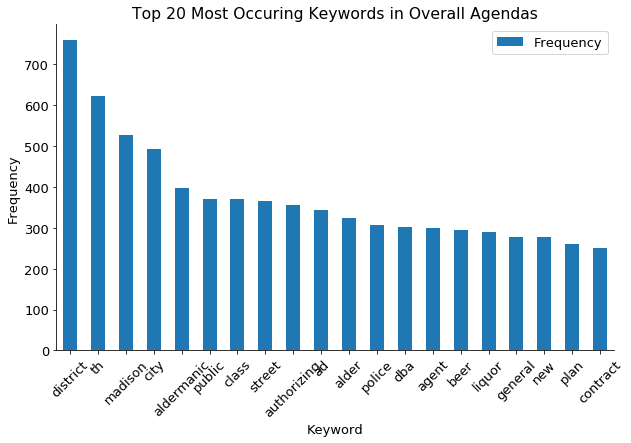

In [19]:
# View most frequently occuring keywords
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

# Convert most freq words to dataframe for plotting bar plot, save as CSV
top_words = get_top_n_words(corpus, n=20)
top_df = DataFrame(top_words)
top_df.columns=["Keyword", "Frequency"]
# print(top_df)
top_df.to_csv('_top_words.csv')

# Barplot of most freq words
# import seaborn as sns
# sns.set(rc={'figure.figsize':(13,8)})
fig, ax = plt.subplots(figsize = (10,6))
# top_df = top_df.drop([1])


top_df.plot.bar(x="Keyword",ax=ax)

ax.set_ylabel("Frequency")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Top 20 Most Occuring Keywords in Overall Agendas')
plt.xticks(rotation=45) 
# g.set_xticklabels(g.get_xticklabels(), rotation=45)
# g.figure.savefig("_keyword.png", bbox_inches = "tight")
# plt.clf()

# plt.savefig('top20keywords.EPS')

In [20]:
top_df
top_n_dict = {}
for i in range(len(top_df['Keyword'])):
#     print(top_df.iloc[i,1])
    if top_df.iloc[i,0]=='th':
        continue
    elif top_df.iloc[i,0]=='alder':
        top_n_dict['ad']+=top_df.iloc[i,1]
        continue
    elif top_df.iloc[i,0]=='liquor':
        top_n_dict['beer']+=top_df.iloc[i,1]
        continue
    elif top_df.iloc[i,0]=='contract':
        top_n_dict['plan']+=top_df.iloc[i,1]
        continue
    top_n_dict[top_df.iloc[i,0]]=top_df.iloc[i,1]
new_not_redundant_df = DataFrame({'Keyword':list(top_n_dict.keys()),'Frequency':list(top_n_dict.values())})
new_not_redundant_df=new_not_redundant_df.sort_values(by='Frequency',ascending=False)

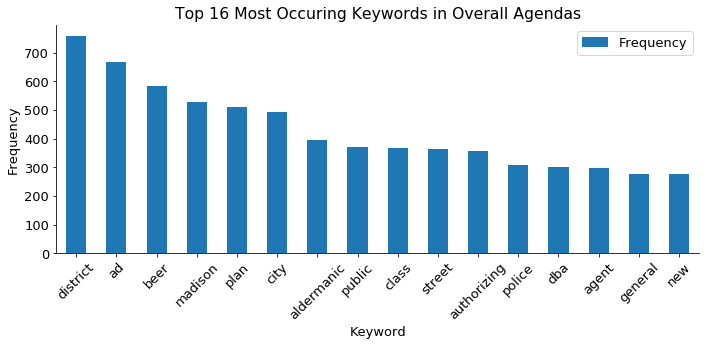

In [21]:
fig, ax = plt.subplots(figsize=(10,5))

new_not_redundant_df.plot.bar(x="Keyword",ax=ax)
ax.set_ylabel("Frequency")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Top '+ str(len(new_not_redundant_df)) +' Most Occuring Keywords in Overall Agendas')
plt.xticks(rotation=45) 
plt.tight_layout()

plt.savefig('top16keywords.pdf', bbox='tight')

In [22]:
important_keys = list(new_not_redundant_df['Keyword'])
important_keys[1]='alder'
important_keys[2]='liquor'
new_not_redundant_df['New_Keywords']=important_keys

In [23]:
new_not_redundant_df

,Keyword,Frequency,New_Keywords
0,district,759,district
8,ad,667,alder
12,beer,583,liquor
1,madison,527,madison
15,plan,511,plan
2,city,492,city
3,aldermanic,396,aldermanic
4,public,370,public
5,class,369,class
6,street,365,street


Adding Committee

In [24]:
committee = ['Common Council Executive Committee',
 'Common Council Executive Committee',
 'Finance Committee',
 'Common Council Executive Committee',
 'Plan Commission',
 'Transportation Commission',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Board of Public Works',
 'Alcohol License Review Committee',
 'Plan Commission',
 'Finance Committee',
 'Urban Design Commission',
 'Landmarks Commission',
 'MATPB',
 'Common Council Executive Committee',
 'Food Policy Council',
 'MATPB',
 'Plan Commission',
 'Finance Committee',
 'Transportation Commission',
 'Board of Park Commissioners',
 'Monona Terrace Community & Convention Center Board',
 'Common Council Executive Committee',
 'Plan Commission',
 'Task Force on Golf in Madison Parks',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Board of Public Works',
 'Alcohol License Review Committee',
 'Zoning Board of Appeals',
 'Common Council Executive Committee',
 'Urban Design Commission',
 'Alcohol License Review Committee',
 'Alcohol License Review Committee',
 'Room Tax Commission',
 'Landmarks Commission',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Board of Public Works',
 'Madison Food Policy Council',
 'Community Development Block Grant Committee',
 'Madison Public Library Board',
 'Plan Commission',
 'Equal Opportunities Commission',
 'Complete Count Committee',
 'Finance Committee',
 'Public Safety Review Committee',
 'Board of Park Commissioners',
 "President's Work Group on Council Communication Tools & Processes",
 'CDA Board',
 'Equal Opportunities Commission',
 'Common Council Executive Committee',
 'Transportation Policy and Planning Board',
 'Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Board of Public Works',
 'Economic Development Committee',
 'Alcohol License Review Committee',
 'MATPB',
 'Monona Terrace Community & Convention Center Board',
 'Monona Terrace Community & Convention Center Board',
 'PSRC',
 'Finance Committee',
 'PSRC',
 'Sustainable Madison Committee',
 'Water Utility Board',
 'MATPB',
 'Transportation Commission',
 'Community Services Committee',
 'Housing Strategy Committee',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Common Council Executive Committee',
 'Monona Terrace Community & Convention Center Board',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Plan Commission',
 'Equal Opportunities Commission',
 'Task Force on Golf in Madison Parks',
 'Monona Terrace Community & Convention Center Board',
 'Madison Food Policy Council',
 'Downtown Coordinating Committee',
 'Landlord and Tenant Issues Committee',
 'Madison Food Policy Council',
 'Urban Design Commission',
 'MATPB',
 'PSRC',
 'Body-Worn Camera Feasibility Review Committee',
 'Madison Public Library Board',
 'Affirmative Action Commission',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals',
 'Transportation Policy and Planning Board',
 'PSRC',
 'Room Tax Commission',
 'Madison Food Policy Council',
 'Madison Arts Commission',
 'Board of Public Works',
 'Public Safety Review Committee',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Madison Food Policy Council',
 'Board of Park Commissioners',
 "President's Work Group on Council Communication Tools & Processes",
 'Community Development Authority Board',
 'Madison Public Library Board',
 'Equal Opportunities Commission',
 'Ad Hoc Task Force on the Structure of City Government (TFOGS) Final Report Implementation Work Group',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Traffic Calming Subcommittee',
 'Landmarks Commission',
 'Plan Commission',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'City-Wide Violence Meeting',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'PSRC',
 'Transportation Policy and Planning Board',
 'Alcohol License Review Committee',
 'Task Force on Golf in Madison Parks',
 'PSRC',
 "President's Work Group on Council Communication Tools & Processes",
 'Monona Terrace Community & Convention Center Board',
 'Monona Terrace Community & Convention Center Board',
 'CDBG Committee',
 'Traffic Calming Subcommittee',
 'Body-Worn Camera Feasibility Review Committee',
 'Finance Committee',
 'Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Personnel Board',
 'Board of Public Works',
 'Transportation Commission',
 "President's Work Group on Council Communication Tools & Processes",
 'Madison Food Policy Council',
 'Housing Strategy Committee',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Task Force on Golf in Madison Parks',
 'Ad Hoc Task Force on the Structure of City Government (TFOGS) Final Report Implementation Work Group',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Finance Committee',
 'Sustainable Madison Committee',
 'Plan Commission',
 'Water Utility Board',
 'Public Safety Review Committee',
 'Food Systems Recovery and Resilience Work Group',
 'Urban Design Commission',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'MLK Commission',
 'Public Safety Review Committee',
 'Plan Commission',
 'Body-Worn Camera Feasibility Review Committee',
 'Task Force on Golf in Madison Parks',
 'Deferred Compensation Committee']

In [25]:
meeting['Committee']=committee

Abbreviations

In [26]:
abbr = {"City-Wide Violence Meeting":"CWVM",
        "Water Utility Board":"WUB",
        "Complete Count Committee":"Count Com.",
        "Madison Public Library Board":"MPLB",
        "Downtown Coordinating Committee":"DC Com.",
        "Madison Food Policy Council":"MFP Coun.",
        "Room Tax Commission":"RT Comm.",
        "Landlord and Tenant Issues Committee":"L&TI Com." ,
        'Personnel Board':"PB" ,
        "CDA Board":"CDAB",
        "Traffic Calming Subcommittee":"TC Subcom.",
        "Affirmative Action Commission":"AA Comm.",
        "Ad Hoc Task Force on the Structure of City Government (TFOGS) Final Report Implementation Work Group":"Ad Hoc W.G.",
        "Community Development Authority Board":"CDAB",
        "CDBG Committee":'CDBG Com.',
        "Board of Public Works":"BPW",
        "Board of Park Commissioners":"BP Comm.",
        'PSRC':"PSRC",
        "Alcohol License Review Committee":"ALR Com.",
        "Body-Worn Camera Feasibility Review Committee":"BWCFR Com.",
        "Finance Committee" :"Finance Com.",
        "Community Services Committee":"CS Com.",
        "MATPB":"MATPB",
        "Plan Commission":"Plan Comm.",
        "Zoning Board of Appeals":"ZBA",
        "Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight":'Alder W.G.',
        "Landmarks Commission":"Land Comm.",
        "Public Safety Review Committee":"PSR Com.",
        "President's Work Group on Council Communication Tools & Processes":"CCTP W.G.",
        "Food Policy Council":"FPC",
        "Transportation Policy and Planning Board":"TPPB",
        "Community Development Block Grant Committee":"CDBGC",
        "Economic Development Committee":"ED Com.",
        "Task Force on Golf in Madison Parks":"TFGMP",
        "Transportation Commission":"TP Comm.",
        "Urban Design Commission":"UD Comm.",
        "Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals":"BBFCL",
        "Monona Terrace Community & Convention Center Board":"MTCCCB",
        "Housing Strategy Committee":"HS Com.",
        "Deferred Compensation Committee":"DefComp Com.",
        "MLK Commission":"MLK Comm.",
        "Common Council Executive Committee":"CCE Com.",
        "Sustainable Madison Committee":"SM Com.",
        "Madison Arts Commission":"MA Comm.",
        "Equal Opportunities Commission":"EO Comm.",
        "Food Systems Recovery and Resilience Work Group":"FSRR W.G."}




In [27]:
abbreviated = []
for i in meeting['Committee']:
    abbreviated.append(abbr[i])
meeting['Abbreviations']=abbreviated

In [28]:
meeting.head(5)

,Meeting_ID,Topic,Scheduled_Start_Time,Zoom_Meeting_Start_Time,Zoom_Meeting_End_Time,Duration,Participants,Recording,Agenda_Link,Minutes_Link,Duration_minutes,day_of_week,day_of_week_coded,starting_formatted,text,note_text,agenda_num,agenda_amount,Committee,Abbreviations
0,954410442,CCEC,4:30:00 PM,3/31/2020 15:40,6:27 PM,2:47:55,52,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,167.917,Tuesday,2,15,COMMON COUNCIL EXECUTIVE COMMITTEECity of Madi...,"City of MadisonMadison, WI 53703www.cityofmad...",Establishing a Body-Worn Camera Feasibility Re...,7,Common Council Executive Committee,CCE Com.
1,531697510,Common Council,6:30:00 PM,3/31/2020 17:04,02:53 AM(Next day),9:48:36,337,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,588.6,Tuesday,2,17,COMMON COUNCILCity of MadisonAgenda - AmendedC...,"City of MadisonMadison, WI 53703www.cityofmad...",Commerating the 50th anniversary of Earth Day ...,116,Common Council Executive Committee,CCE Com.
2,411578576,"Finance Committee: Meeting of April 6, 2020",4:30:00 PM,4/6/2020 15:40,5:49 PM,2:09:00,31,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,129,Monday,1,15,FINANCE COMMITTEECity of MadisonAgenda - Appro...,"City of MadisonMadison, WI 53703www.cityofmad...",A Resolution to authorize the noncompetitive p...,6,Finance Committee,Finance Com.
3,563608269,"CCEC: Meeting of April 9, 2020",6:00:00 PM,4/9/2020 16:57,7:53 PM,2:56:08,36,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,176.133,Thursday,4,16,COMMON COUNCIL EXECUTIVE COMMITTEECity of Madi...,"City of MadisonMadison, WI 53703www.cityofmad...",Discuss Council's Role & Response during COVID...,2,Common Council Executive Committee,CCE Com.
4,468948855,"Plan Commission: Meeting of April 13, 2020",5:30:00 PM,4/13/2020 16:35,9:14 PM,4:38:54,80,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,278.9,Monday,1,16,PLAN COMMISSIONCity of MadisonAgenda - Approve...,"City of MadisonMadison, WI 53703www.cityofmad...",General Public Correspondence to the Plan Comm...,22,Plan Commission,Plan Comm.


**Making X_DF for Regression**

In [29]:
X_df = meeting[['agenda_amount','Duration_minutes','starting_formatted','day_of_week_coded']].copy().copy()
X_df['before_work']=''
X_df['during_work']=''
X_df['after_work']=''
for index, rows in X_df.iterrows():
    if 9<=rows['starting_formatted']<=17:
        X_df.at[index, 'during_work']=1
        X_df.at[index, 'before_work']=0
        X_df.at[index, 'after_work']=0
    elif rows['starting_formatted'] >17:
        X_df.at[index, 'during_work']=0
        X_df.at[index, 'before_work']=0
        X_df.at[index, 'after_work']=1
    else:
        X_df.at[index, 'during_work']=0
        X_df.at[index, 'before_work']=1
        X_df.at[index, 'after_work']=0
del X_df['starting_formatted']

In [30]:
X_df['Monday']=''
X_df['Tuesday']=''
X_df['Wednesday']=''
X_df['Thursday']=''
X_df['Friday']=''
X_df['Saturday']=''
for index, rows in X_df.iterrows():
    if rows['day_of_week_coded']=="1":
        X_df.at[index, 'Monday']=1
        X_df.at[index, 'Tuesday']=0
        X_df.at[index, 'Wednesday']=0
        X_df.at[index, 'Thursday']=0
        X_df.at[index, 'Friday']=0
        X_df.at[index, 'Saturday']=0
    elif rows['day_of_week_coded']=='2':
        X_df.at[index, 'Monday']=0
        X_df.at[index, 'Tuesday']=1
        X_df.at[index, 'Wednesday']=0
        X_df.at[index, 'Thursday']=0
        X_df.at[index, 'Friday']=0
        X_df.at[index, 'Saturday']=0
    elif rows['day_of_week_coded']=='3':
        X_df.at[index, 'Monday']=0
        X_df.at[index, 'Tuesday']=0
        X_df.at[index, 'Wednesday']=1
        X_df.at[index, 'Thursday']=0
        X_df.at[index, 'Friday']=0
        X_df.at[index, 'Saturday']=0
    elif rows['day_of_week_coded']=="4":
        X_df.at[index, 'Monday']=0
        X_df.at[index, 'Tuesday']=0
        X_df.at[index, 'Wednesday']=0
        X_df.at[index, 'Thursday']=1
        X_df.at[index, 'Friday']=0
        X_df.at[index, 'Saturday']=0
    elif rows['day_of_week_coded']=="5":
        X_df.at[index, 'Monday']=0
        X_df.at[index, 'Tuesday']=0
        X_df.at[index, 'Wednesday']=0
        X_df.at[index, 'Thursday']=0
        X_df.at[index, 'Friday']=1
        X_df.at[index, 'Saturday']=0
    elif rows['day_of_week_coded']=="6":
        X_df.at[index, 'Monday']=0
        X_df.at[index, 'Tuesday']=0
        X_df.at[index, 'Wednesday']=0
        X_df.at[index, 'Thursday']=0
        X_df.at[index, 'Friday']=0
        X_df.at[index, 'Saturday']=1
del X_df['day_of_week_coded']

Adding Committee

In [31]:
unique_committee = list(set(meeting['Abbreviations']))
for i in unique_committee:
    print(i)

MFP Coun.
BBFCL
ALR Com.
RT Comm.
CWVM
ZBA
FPC
SM Com.
Alder W.G.
MATPB
DefComp Com.
EO Comm.
CDBGC
Count Com.
WUB
MTCCCB
Land Comm.
TC Subcom.
BP Comm.
AA Comm.
TPPB
FSRR W.G.
CCTP W.G.
PB
L&TI Com.
BPW
PSRC
HS Com.
CDBG Com.
MPLB
TFGMP
Plan Comm.
CCE Com.
CS Com.
DC Com.
Ad Hoc W.G.
ED Com.
MA Comm.
CDAB
TP Comm.
BWCFR Com.
Finance Com.
MLK Comm.
UD Comm.
PSR Com.


In [32]:
for i in unique_committee:
    tracker = []
    for x in meeting['Abbreviations']:
        if x==i:
            tracker.append(1)
        else:
            tracker.append(0)
    X_df[i]=tracker

Adding Top Words

In [33]:
for top_word in new_not_redundant_df['New_Keywords']:
    word_count=[]
    for text in meeting['note_text']:
        if top_word in text.lower().split():
            word_count.append(1)
        else:
            word_count.append(0)
    X_df[top_word]=word_count

In [34]:
X_df

,agenda_amount,Duration_minutes,before_work,during_work,after_work,Monday,Tuesday,Wednesday,Thursday,Friday,...,aldermanic,public,class,street,authorizing,police,dba,agent,general,new
0,7,167.917,0,1,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
1,116,588.6,0,1,0,0,1,0,0,0,...,1,1,0,1,1,1,0,0,1,1
2,6,129,0,1,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
3,2,176.133,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
4,22,278.9,0,1,0,1,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,3,150.833,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
151,2,248.483,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
152,5,148.183,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
153,1,169.45,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


## **Lasso**

In [35]:
from sklearn import linear_model

In [36]:
clf = linear_model.Lasso(alpha=0.1)

In [37]:
clf.fit(X_df, meeting['Participants'])

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [38]:
agenda_numbers=10
Duration_minutes=50
day_of_week_coded=5
starting_coded=3
district =0
alder=0
liquor=0
madison =0
plan = 0
city= 0
aldermanic = 0
public = 0
class_=0 
street = 0
authorizing = 0
police = 0
dba =0
agent = 0
general =0
new = 0
cam =0# Body-Worn Camera Feasibility Review Committee
CDBG =0# CDBG Committee
PSRC=0# PSRC
WUB=0# Water Utility Board
DCC=0# Deferred Compensation Committee
MAC=0# Madison Arts Commission
FPC=0# Food Policy Council
EOC=0# Equal Opportunities Commission
PB=0# Personnel Board
LC=0# Landmarks Commission
PC=0# Plan Commission
violence=0# City-Wide Violence Meeting
alc =0# Alcohol License Review Committee
safety=0# Public Safety Review Committee
count=0# Complete Count Committee
CCEC=0# Common Council Executive Committee
task_park=0# Task Force on Golf in Madison Parks
MLK=0# MLK Commission
UDC=0# Urban Design Commission
TCS=0# Traffic Calming Subcommittee
BPC=0# Board of Park Commissioners
TC=0# Transportation Commission
HSC=0# Housing Strategy Committee
alder=0# Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight
SMC=0# Sustainable Madison Committee
CDAB=0# Community Development Authority Board
finance=0# Finance Committee
ad_hoc=0# Ad Hoc Task Force on the Structure of City Government (TFOGS) Final Report Implementation Work Group
grant=0# Community Development Block Grant Committee
BPW=0# Board of Public Works
zone=0# Zoning Board of Appeals
food_recovery=0# Food Systems Recovery and Resilience Work Group
code=0# Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals
tools=0# President's Work Group on Council Communication Tools & Processes
landlord=0# Landlord and Tenant Issues Committee
food_policy=0# Madison Food Policy Council
transport=0# Transportation Policy and Planning Board
CDA=0# CDA Board
MATPB=0# MATPB
library=0# Madison Public Library Board
terrace=0# Monona Terrace Community & Convention Center Board
downtown=0# Downtown Coordinating Committee
AAC=0# Affirmative Action Commission
tax=0# Room Tax Commission
CSC=0# Community Services Committee
econ=0# Economic Development Committee

# predicted = clf.predict([[agenda_numbers,Duration_minutes,day_of_week_coded,starting_coded,district,alder, liquor, madison, plan, city, aldermanic, public, class_, street, authorizing, police, dba, agent, general, new,cam,CDBG,PSRC,WUB,DCC,MAC,FPC,EOC,PB,LC,PC,violence,alc,safety,count,CCEC,task_park,MLK,UDC,TCS,BPC,TC,HSC,alder,SMC,CDAB,finance,ad_hoc,grant,BPW,zone,food_recovery,code,tools,landlord,food_policy,transport,CDA,MATPB,library,terrace,downtown,AAC,tax,CSC,econ]])
                          

# print('(Model with Committee) The number of Partipants will be around {} people \n'.format(predicted))

print("Keywords from agenda_num applied on agenda_num")


def formula(reg, columns):
    rv = ""
    for i in range(len(columns)):
        rv += "{}*({}) +".format(round(reg.coef_[i],4), columns[i])
    rv += str(reg.intercept_)
    return rv

print("Number of Participants ~= " + formula(clf, list(X_df.columns)))





Keywords from agenda_num applied on agenda_num
Number of Participants ~= 0.2291*(agenda_amount) +0.3454*(Duration_minutes) +-8.8571*(before_work) +0.0*(during_work) +17.802*(after_work) +-1.3217*(Monday) +3.2768*(Tuesday) +1.2091*(Wednesday) +-2.5825*(Thursday) +-0.0*(Friday) +0.0*(Saturday) +9.6159*(MFP Coun.) +24.4014*(BBFCL) +-9.1323*(ALR Com.) +-9.9976*(RT Comm.) +0.0*(CWVM) +-10.8268*(ZBA) +-0.0*(FPC) +0.0*(SM Com.) +-0.3417*(Alder W.G.) +-5.4235*(MATPB) +0.0*(DefComp Com.) +0.605*(EO Comm.) +0.0*(CDBGC) +0.0*(Count Com.) +0.0*(WUB) +3.4145*(MTCCCB) +-21.878*(Land Comm.) +0.0*(TC Subcom.) +-15.2286*(BP Comm.) +-0.2642*(AA Comm.) +-26.6206*(TPPB) +0.0*(FSRR W.G.) +-6.2504*(CCTP W.G.) +10.7525*(PB) +-0.0*(L&TI Com.) +-19.4617*(BPW) +-0.0*(PSRC) +1.482*(HS Com.) +-10.867*(CDBG Com.) +113.5793*(MPLB) +21.2305*(TFGMP) +4.1021*(Plan Comm.) +6.4241*(CCE Com.) +0.0*(CS Com.) +-18.4917*(DC Com.) +0.0*(Ad Hoc W.G.) +0.4546*(ED Com.) +0.0*(MA Comm.) +14.4062*(CDAB) +-40.5501*(TP Comm.) +-18.

**Plotting With Every Coefficient**

In [39]:
pd.set_option('display.max_rows', None)

In [40]:
coef_df_committee = DataFrame({'Column':list(X_df.columns), 'Coefficients':list(clf.coef_)})
coef_df_committee

,Column,Coefficients
0,agenda_amount,0.229133
1,Duration_minutes,0.345395
2,before_work,-8.857121
3,during_work,0.000000
4,after_work,17.801966
5,Monday,-1.321736
6,Tuesday,3.276772
7,Wednesday,1.209142
8,Thursday,-2.582530
9,Friday,-0.000000


**Plotting with Coefficients not zero**

In [41]:
import math

In [42]:
coef_not_zero = coef_df_committee[abs(coef_df_committee['Coefficients'])>0.1]
coef_not_zero=coef_not_zero.sort_values(by="Coefficients",ascending=True)
coef_not_zero

,Column,Coefficients
50,TP Comm.,-40.550068
31,TPPB,-26.620606
27,Land Comm.,-21.877970
64,class,-21.851764
36,BPW,-19.461719
45,DC Com.,-18.491694
51,BWCFR Com.,-18.485835
68,dba,-16.561851
70,general,-15.679587
29,BP Comm.,-15.228603


In [43]:
counter = coef_not_zero.copy().copy()
counter['index']=[i for i in range(len(coef_not_zero))]
counter

,Column,Coefficients,index
50,TP Comm.,-40.550068,0
31,TPPB,-26.620606,1
27,Land Comm.,-21.877970,2
64,class,-21.851764,3
36,BPW,-19.461719,4
45,DC Com.,-18.491694,5
51,BWCFR Com.,-18.485835,6
68,dba,-16.561851,7
70,general,-15.679587,8
29,BP Comm.,-15.228603,9


**Coefficients that got removed**

In [44]:
len(coef_df_committee[abs(coef_df_committee['Coefficients'])<=0.1])

22

**Actual Plotting now**

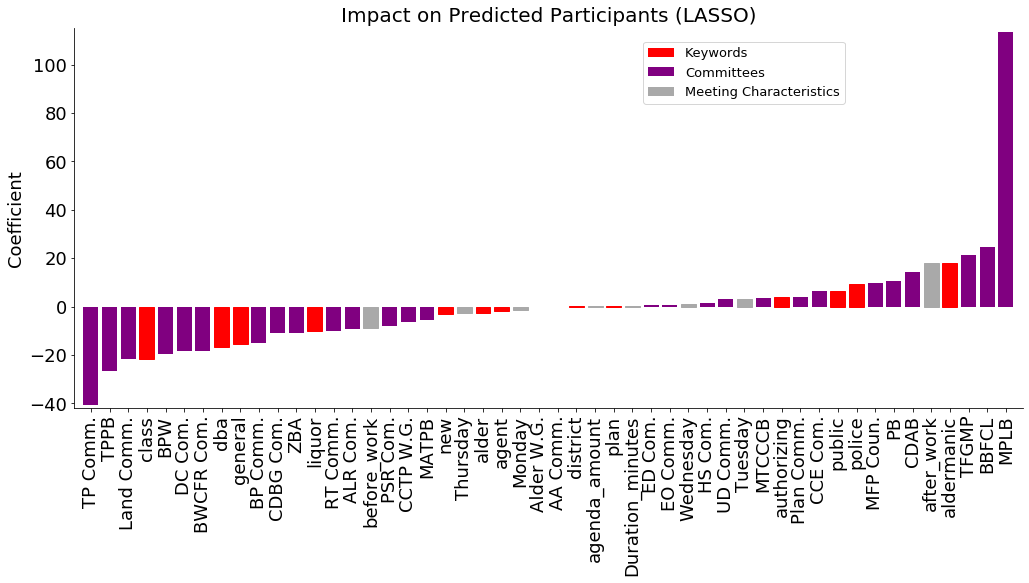

In [45]:
fig,ax=plt.subplots(figsize=(17,7))

barlist = plt.bar(x=coef_not_zero['Column'], height = coef_not_zero['Coefficients'], color='purple')
plt.xticks(rotation=90) 
# plt.tight_layout()
plt.xticks(size = 18)
plt.yticks(size = 18)
# ax.xaxis.tick_top()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Coefficient',size=18)
ax.set_title('Impact on Predicted Participants (LASSO)',size=20)

barlist[3].set_color('r')
barlist[7].set_color('r')
barlist[8].set_color('r')
barlist[12].set_color('r')
barlist[19].set_color('r')
barlist[21].set_color('r')
barlist[22].set_color('r')
barlist[26].set_color('r')
barlist[28].set_color('r')
barlist[37].set_color('r')
barlist[40].set_color('r')
barlist[41].set_color('r')
barlist[46].set_color('r')

barlist[15].set_color('darkgrey')
barlist[20].set_color('darkgrey')
barlist[23].set_color('darkgrey')
barlist[27].set_color('darkgrey')
barlist[29].set_color('darkgrey')
barlist[32].set_color('darkgrey')
barlist[35].set_color('darkgrey')
barlist[45].set_color('darkgrey')
plt.margins(0.01)


# ax.legend()
# ax.set_xlim(len(coef_not_zero))

legend_elements = [Patch(facecolor='r',label='Keywords'),
                   Patch(facecolor='purple',label='Committees'),
                   Patch(facecolor='darkgrey',label='Meeting Characteristics')]

ax.legend(handles=legend_elements, loc=(.6,.8))

plt.savefig('lasso_coef_flat.pdf',bbox_inches = "tight")


Testing (With Keywords)

In [92]:
import sklearn
from sklearn import *
from sklearn.model_selection import train_test_split

In [93]:
test_df = X_df.copy().copy()
test_df['Participants']=meeting['Participants']
train, test = train_test_split(test_df)
clf_train = linear_model.Lasso(alpha=0.1)
clf_train.fit(train.loc[:, train.columns != 'Participants'], train["Participants"])
# print("Training Score: ",clf.score(train.loc[:, train.columns != 'Participants'], train["Participants"]),"\n"
#  "Testing Score: ", clf.score(test.loc[:, test.columns != 'Participants'], test["Participants"]))


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

**EXPLAINED VARIANCE SCORE**

In [94]:
sklearn.metrics.explained_variance_score(test_df['Participants'],clf_train.predict(X_df))

0.749487111522182

Testing Function for different alpha

In [143]:
def testing_alpha(data,a):
    test_df = data.copy().copy()
    test_df['Participants']=meeting['Participants']
    train, test = train_test_split(test_df)
    model = linear_model.Lasso(alpha=a)
    model.fit(train.loc[:, train.columns != 'Participants'], train["Participants"])
#     print("Training Score: ",clf.score(train.loc[:, train.columns != 'Participants'], train["Participants"]),"\n"
#      "Testing Score: ", clf.score(test.loc[:, test.columns != 'Participants'], test["Participants"]))
    return model.score(test.loc[:, test.columns != 'Participants'], test["Participants"])

In [176]:
for i in [.001,.01,.1,1,1.5,2]:
    print('alpha:', i ,',score:' ,testing_alpha(X_df,i))

alpha: 0.001 ,score: 0.34537198736472907
alpha: 0.01 ,score: 0.4226484848690658
alpha: 0.1 ,score: -0.11434661507286159
alpha: 1 ,score: 0.7103930997389033
alpha: 1.5 ,score: 0.6627528831224849
alpha: 2 ,score: 0.7029435550646405


## Standard Scalar

In [99]:
from sklearn import *
from sklearn.preprocessing import StandardScaler

In [100]:
scalar = StandardScaler()

In [101]:
new_agenda = scalar.fit_transform(X_df[['agenda_amount']])

In [102]:
new_duration = scalar.fit_transform(X_df[['Duration_minutes']])

In [103]:
scaled_X_df = X_df.copy().copy()

In [104]:
scaled_X_df['Duration_minutes']=new_duration
scaled_X_df['agenda_amount']=new_agenda
scaled_X_df

,agenda_amount,Duration_minutes,before_work,during_work,after_work,Monday,Tuesday,Wednesday,Thursday,Friday,...,aldermanic,public,class,street,authorizing,police,dba,agent,general,new
0,-0.268371,-0.260248,0,1,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
1,4.320824,3.397132,0,1,0,0,1,0,0,0,...,1,1,0,1,1,1,0,0,1,1
2,-0.310474,-0.598585,0,1,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
3,-0.478884,-0.188813,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
4,0.363170,0.704631,0,1,0,1,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
5,-0.184165,1.083395,0,1,0,0,0,1,0,0,...,0,1,0,1,1,0,0,0,1,1
6,-0.436782,-0.304007,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
7,-0.394679,-0.989087,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,1
8,3.268257,1.282630,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,1
9,1.036813,0.172709,0,1,0,0,0,1,0,0,...,1,1,0,1,1,1,0,0,1,1


In [105]:
scaled_X_df['Participants']=meeting['Participants']
train, test = train_test_split(scaled_X_df)
scaled_lr = linear_model.Lasso(alpha=0.1)
scaled_lr.fit(train.loc[:, train.columns != 'Participants'], train["Participants"])
print("Training Score: ",scaled_lr.score(train.loc[:, train.columns != 'Participants'], train["Participants"]),"\n"
 "Testing Score: ", scaled_lr.score(test.loc[:, test.columns != 'Participants'], test["Participants"]))



Training Score:  0.8228992721287921 
Testing Score:  0.7299566534908105


In [109]:
coef_df_scaled = DataFrame({'Column':list(train.loc[:, train.columns != 'Participants'].columns), 'Coefficients':list(scaled_lr.coef_)})
coef_df_scaled

,Column,Coefficients
0,agenda_amount,8.715034
1,Duration_minutes,35.629791
2,before_work,-9.697117
3,during_work,-0.000000
4,after_work,32.300564
5,Monday,-1.333356
6,Tuesday,3.112198
7,Wednesday,-0.430658
8,Thursday,0.330251
9,Friday,-0.000000


In [112]:
not_zero = coef_df_scaled[abs(coef_df_scaled['Coefficients'])>0.1]
not_zero=not_zero.sort_values(by="Coefficients",ascending=True)
not_zero

,Column,Coefficients
50,TP Comm.,-45.049231
27,Land Comm.,-36.921243
31,TPPB,-31.773436
36,BPW,-25.903814
51,BWCFR Com.,-25.879530
58,liquor,-25.292474
39,CDBG Com.,-23.138361
45,DC Com.,-22.267524
64,class,-19.897506
29,BP Comm.,-18.823577


In [114]:
counter_scaled = not_zero.copy().copy()
counter_scaled['index']=[i for i in range(len(not_zero))]
counter_scaled

,Column,Coefficients,index
50,TP Comm.,-45.049231,0
27,Land Comm.,-36.921243,1
31,TPPB,-31.773436,2
36,BPW,-25.903814,3
51,BWCFR Com.,-25.879530,4
58,liquor,-25.292474,5
39,CDBG Com.,-23.138361,6
45,DC Com.,-22.267524,7
64,class,-19.897506,8
29,BP Comm.,-18.823577,9


We see that the Madison Public Library Board has the most impact on the predicted number of participants. Additionally starting time has a positive impact on the predicted number of participants as well. This could indicate that meetings that hope to have a higher number of participants should host their meetings towards the end of the workday. The model predicts that meetings after work can have an increase in about 32 participants Words such as ``aldermanic", ``police," and ``authorizing" also have a positive impact. Additionally, the model shoes the highest that Tuesdays and after\_work have the highest impact on participants with an expected increase of 3.112198 and 32.300564, respectively. Furthermore, if a meeting is discussing something related to an aldermanic district and police, the model predicts an increase in 15.526517 and 12.099811 participants, respectively. We hypothesize that people are interested in meetings that are dealing with local issues since aldermanic is tied to aldermanic district. 


In [117]:
len(coef_df_scaled[abs(coef_df_scaled['Coefficients'])<=0.1])

27

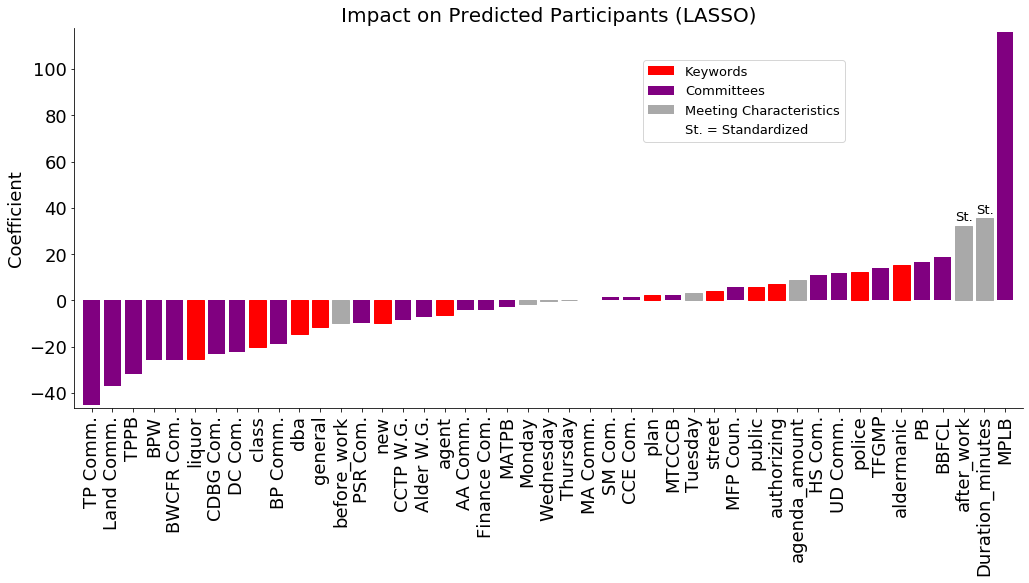

In [130]:
fig,ax=plt.subplots(figsize=(17,7))

barlist = plt.bar(x=not_zero['Column'], height = not_zero['Coefficients'], color='purple')
plt.xticks(rotation=90) 
# plt.tight_layout()
plt.xticks(size = 18)
plt.yticks(size = 18)
# ax.xaxis.tick_top()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Coefficient',size=18)
ax.set_title('Impact on Predicted Participants (LASSO)',size=20)
barlist[5].set_color('r')
barlist[8].set_color('r')
barlist[10].set_color('r')
barlist[11].set_color('r')
barlist[14].set_color('r')
barlist[17].set_color('r')
barlist[27].set_color('r')
barlist[30].set_color('r')
barlist[32].set_color('r')
barlist[33].set_color('r')
barlist[37].set_color('r')
barlist[39].set_color('r')

barlist[12].set_color('darkgrey')
barlist[21].set_color('darkgrey')
barlist[22].set_color('darkgrey')
barlist[23].set_color('darkgrey')
barlist[29].set_color('darkgrey')
barlist[34].set_color('darkgrey')
barlist[42].set_color('darkgrey')
barlist[43].set_color('darkgrey')
plt.margins(0.01)
ax.text(barlist[42].get_x(), barlist[42].get_height()+2, 'St.')
ax.text(barlist[43].get_x(), barlist[43].get_height()+2, 'St.')


# ax.legend()
# ax.set_xlim(len(coef_not_zero))

legend_elements = [Patch(facecolor='r',label='Keywords'),
                   Patch(facecolor='purple',label='Committees'),
                   Patch(facecolor='darkgrey',label='Meeting Characteristics'),
                   Patch(facecolor='white',label='St. = Standardized')]

ax.legend(handles=legend_elements, loc=(.6,.7))

plt.savefig('lasso_coef_flat.pdf',bbox_inches = "tight")



In [120]:
def formula(reg, columns):
    rv = ""
    for i in range(len(columns)):
        rv += "{}*({}) +".format(round(reg.coef_[i],4), columns[i])
    rv += str(reg.intercept_)
    return rv

print("Number of Participants ~= " + formula(scaled_lr, list(scaled_X_df.loc[:, scaled_X_df.columns != 'Participants'].columns)))

Number of Participants ~= 8.715*(agenda_amount) +35.6298*(Duration_minutes) +-9.6971*(before_work) +-0.0*(during_work) +32.3006*(after_work) +-1.3334*(Monday) +3.1122*(Tuesday) +-0.4307*(Wednesday) +0.3303*(Thursday) +-0.0*(Friday) +0.0*(Saturday) +5.8277*(MFP Coun.) +18.7781*(BBFCL) +-0.0*(ALR Com.) +-0.0*(RT Comm.) +0.0*(CWVM) +0.0*(ZBA) +0.0*(FPC) +1.2887*(SM Com.) +-7.1603*(Alder W.G.) +-2.9265*(MATPB) +0.0*(DefComp Com.) +0.0*(EO Comm.) +0.0*(CDBGC) +0.0*(Count Com.) +-0.0*(WUB) +2.4648*(MTCCCB) +-36.9212*(Land Comm.) +0.0*(TC Subcom.) +-18.8236*(BP Comm.) +-4.3*(AA Comm.) +-31.7734*(TPPB) +0.0*(FSRR W.G.) +-8.6121*(CCTP W.G.) +16.6627*(PB) +-0.0*(L&TI Com.) +-25.9038*(BPW) +-0.0*(PSRC) +10.8081*(HS Com.) +-23.1384*(CDBG Com.) +116.2062*(MPLB) +14.1907*(TFGMP) +0.0056*(Plan Comm.) +1.5676*(CCE Com.) +0.0*(CS Com.) +-22.2675*(DC Com.) +-0.0*(Ad Hoc W.G.) +0.0*(ED Com.) +0.3669*(MA Comm.) +0.0*(CDAB) +-45.0492*(TP Comm.) +-25.8795*(BWCFR Com.) +-4.1681*(Finance Com.) +0.0*(MLK Comm.

In [115]:
sklearn.metrics.explained_variance_score(scaled_X_df['Participants'],scaled_lr.predict(scaled_X_df.loc[:, scaled_X_df.columns != 'Participants']))

0.7991142281835254